In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

from collections import OrderedDict
import glob
import json
import os
from pathlib import Path
import pickle
import re
import shutil

from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from keras.preprocessing.image import (ImageDataGenerator, array_to_img,
                                       img_to_array, load_img)
from keras.utils import plot_model
from nltk.corpus import wordnet as wn
import networkx as nx
from networkx.algorithms.shortest_paths.generic import shortest_path_length as nx_shortest_path_length
from networkx.algorithms.shortest_paths.unweighted import single_source_shortest_path as nx_single_source_shortest_path
import pandas as pd
from scipy.spatial.distance import cdist, pdist
from skimage.transform import resize
from sklearn.neighbors import BallTree
import seaborn as sns
import somoclu
import spacy
import tensorflow as tf
from tqdm import tqdm_notebook as tqdmn, tqdm_pandas as tqdmpd

from AlexNet import AlexNet, preprocess_image_batch
import multimodal_som as mmsom


def show_imgs(imgs, ax=None):
    N, M, IN, IM, C = imgs.shape
    imgs = imgs.transpose(0, 2, 1, 3, 4).reshape(N*IN, M*IM, C)
    if ax is None:
        ax = plt.figure(figsize=(16, 8)).gca()
    ax.imshow(imgs)


img_dir = Path('/data/master_thesis/Flickr8k_Dataset/')
mmsom.tqdm = tqdmn
sns.set(style='ticks', context='poster')
pd.set_option('display.max_rows', 12)

Populating the interactive namespace from numpy and matplotlib


/home/mtambos/anaconda/envs/thesis/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/mtambos/anaconda/envs/thesis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def get_nhop_set(base_wnids, wn_is_a, n_hops, super_wnids=None):
    g = nx.Graph()
    g.add_edges_from(wn_is_a.as_matrix())
    base_wnids = set(base_wnids)
    if super_wnids is None:
        super_wnids = set(wn_is_a.wnid) | set(wn_is_a.parent_wnid)
    super_wnids = set(super_wnids)

    ret_val = set(base_wnids)
    for base_wnid in tqdmn(base_wnids):
        paths = nx_shortest_path_length(g, source=base_wnid)
        paths = sorted(paths.items(), key=lambda x: x[1])
        for wnid, hops in paths:
            if hops > n_hops:
                break
            elif wnid in super_wnids:
                ret_val.add(wnid)
    return ret_val


def get_nhop_k_set(true_wnids, wn_is_a, k, valid_wnids=None):
    g = nx.Graph()
    g.add_edges_from(wn_is_a.as_matrix())
    true_wnids = set(true_wnids)
    if valid_wnids is None:
        valid_wnids = set(wn_is_a.wnid) | set(wn_is_a.parent_wnid)
    valid_wnids = set(valid_wnids)

    ret_val = {true_wnid: set() for true_wnid in true_wnids}
    for true_wnid in tqdmn(true_wnids):
        correct_true_wnid = ret_val[true_wnid]
        if true_wnid not in g.nodes:
            correct_true_wnid.add(true_wnid)
            continue
        paths = nx_shortest_path_length(g, source=true_wnid)
        paths = sorted(paths.items(), key=lambda x: x[1])
        n_hops = 0
        while len(correct_true_wnid) < k and n_hops < len(valid_wnids):
            radius_set = {true_wnid}
            for wnid, hops in paths:
                if hops > n_hops:
                    break
                radius_set.add(wnid)
            
            radius_set &= valid_wnids
            correct_true_wnid.update(radius_set)
            n_hops += 1
    return ret_val

In [3]:
from multiset import Multiset

def hp_at_k(y_true, y_pred, correct_sets, k):
    return len(Multiset(y_pred[:k]) & Multiset(correct_sets[y_true]))/k

In [4]:
wn_is_a = pd.read_table('/data/master_thesis/wordnet.is_a.txt', names=['parent_wnid', 'wnid'], sep=' ')
wn_is_a.head()

,parent_wnid,wnid
0,n02118333,n02119789
1,n02471300,n02478875
2,n02471762,n02473983
3,n02100399,n02100735
4,n02374149,n02390258


In [5]:
nlp = spacy.load('en_core_web_md')

In [4]:
vec2word = pd.read_csv('vec2word.csv')
vec2word.head()

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_291,vector_292,vector_293,vector_294,vector_295,vector_296,vector_297,vector_298,vector_299,word
0,0.385300,0.13618,0.59719,0.183430,-0.141900,-0.064433,0.091606,0.57574,0.88234,0.63385,...,-0.063343,-0.72641,0.592020,0.14770,-0.091060,-0.111260,-0.32848,0.565230,-0.67985,wicket
1,-0.016269,-0.66774,-0.21387,-0.479190,-0.624370,0.551470,-0.091257,-0.26658,0.36018,0.88362,...,0.087071,-0.31702,0.490470,-0.24666,0.655510,0.140950,0.53461,-0.324080,0.24846,monkey
2,-0.400600,-0.16396,0.40008,0.835210,-0.357100,0.827780,-0.138230,-0.16133,-0.23525,1.46380,...,-0.412130,-0.43138,0.003545,0.00082,-0.367900,-0.242250,-0.65519,-0.242870,0.55420,source
3,0.012832,0.22669,-0.17511,0.602480,0.096562,-0.206570,0.390550,-0.64990,0.12015,3.19590,...,0.086623,-0.16848,0.424830,0.34597,0.029642,0.002229,0.17134,0.040047,-0.37131,mother
4,0.693840,-1.34820,0.30036,0.009335,-0.206420,-0.016727,0.267700,-0.54181,-0.53659,0.58871,...,-0.250110,0.10779,0.265700,-0.17284,0.312720,0.003351,0.53952,0.252890,-0.35419,drap


In [6]:
test_words = pd.read_csv('test_words.csv', index_col='fname')
test_words.head()

,doc_rank,word
fname,,
/data/master_thesis/Flickr30k_Dataset/2384507273.jpg,0,workers
/data/master_thesis/Flickr30k_Dataset/2384507273.jpg,0,scaffolding
/data/master_thesis/Flickr30k_Dataset/2384507273.jpg,0,street
/data/master_thesis/Flickr30k_Dataset/2384507273.jpg,0,business
/data/master_thesis/Flickr30k_Dataset/2384507273.jpg,1,men


In [40]:
true_wnids = set(f'{ss.pos()}{ss.offset():>08}'.lower()
                 for w in vec2word.word
                 for ss in wn.synsets(w) if ss.pos() == 'n')
len(true_wnids), len(vec2word.word)

(8035, 3633)

In [42]:
flickr8k_word_2k = get_nhop_k_set(true_wnids, wn_is_a, 2)

HBox(children=(IntProgress(value=0, max=8035), HTML(value='')))

In [46]:
flickr8k_word_5k = get_nhop_k_set(true_wnids, wn_is_a, 5)

HBox(children=(IntProgress(value=0, max=8035), HTML(value='')))

In [47]:
flickr8k_word_10k = get_nhop_k_set(true_wnids, wn_is_a, 10)

HBox(children=(IntProgress(value=0, max=8035), HTML(value='')))

In [48]:
flickr8k_word_20k = get_nhop_k_set(true_wnids, wn_is_a, 20)

HBox(children=(IntProgress(value=0, max=8035), HTML(value='')))

In [52]:
with open('flickr8k_word_2k.pickle', 'wb') as fp:
    pickle.dump(flickr8k_word_2k, fp)

with open('flickr8k_word_5k.pickle', 'wb') as fp:
    pickle.dump(flickr8k_word_5k, fp)

with open('flickr8k_word_10k.pickle', 'wb') as fp:
    pickle.dump(flickr8k_word_10k, fp)

with open('flickr8k_word_20k.pickle', 'wb') as fp:
    pickle.dump(flickr8k_word_20k, fp)

In [59]:
with open('results_words.pickle', 'rb') as fp:
    results = pickle.load(fp)
list(results.items())[0]

(('101669240_b2d3e7f17b.jpg', 1, 'hat'),
 Index(['/data/master_thesis/Flickr8k_Dataset/370442541_60d93ecd13.jpg',
        '/data/master_thesis/Flickr8k_Dataset/2844963839_ff09cdb81f.jpg',
        '/data/master_thesis/Flickr8k_Dataset/3368865171_597d51cdd5.jpg',
        '/data/master_thesis/Flickr8k_Dataset/2500354186_0836309cc9.jpg',
        '/data/master_thesis/Flickr8k_Dataset/241345446_2e47ae8ddc.jpg',
        '/data/master_thesis/Flickr8k_Dataset/3561639055_5ac66ae92f.jpg',
        '/data/master_thesis/Flickr8k_Dataset/2039457436_fc30f5e1ce.jpg',
        '/data/master_thesis/Flickr8k_Dataset/405961988_fcfe97f31e.jpg',
        '/data/master_thesis/Flickr8k_Dataset/3039214579_43ef79f931.jpg',
        '/data/master_thesis/Flickr8k_Dataset/241345942_ea76966542.jpg',
        '/data/master_thesis/Flickr8k_Dataset/2009636597_e3f4fe19fb.jpg',
        '/data/master_thesis/Flickr8k_Dataset/3606084228_6286a52875.jpg',
        '/data/master_thesis/Flickr8k_Dataset/2896668718_0c3cff910f.jpg',
 

In [87]:
np.mean([
    hp_at_k(f'{ss.pos()}{ss.offset():>08}'.lower(),
            list(OrderedDict([
                (f'{s.pos()}{s.offset():>08}'.lower(), None)
                for fname in img_pred
                for w in test_words.loc[Path(fname).name, 'word']
                for s in wn.synsets(w) if s.pos() == 'n'
            ]).keys()),
            flickr8k_word_2k,
            2)
    for (img_true, _, word), img_pred in tqdmn(results.items(), total=len(results))
    for ss in wn.synsets(word) if ss.pos() == 'n'
    if f'{ss.pos()}{ss.offset():>08}'.lower() in flickr8k_word_2k
])

HBox(children=(IntProgress(value=0, max=15172), HTML(value='')))

0.027001724230831404

In [88]:
np.mean([
    hp_at_k(f'{ss.pos()}{ss.offset():>08}'.lower(),
            list(OrderedDict([
                (f'{s.pos()}{s.offset():>08}'.lower(), None)
                for fname in img_pred
                for w in test_words.loc[Path(fname).name, 'word']
                for s in wn.synsets(w) if s.pos() == 'n'
            ]).keys()),
            flickr8k_word_5k,
            5)
    for (img_true, _, word), img_pred in tqdmn(results.items(), total=len(results))
    for ss in wn.synsets(word) if ss.pos() == 'n'
    if f'{ss.pos()}{ss.offset():>08}'.lower() in flickr8k_word_5k
])

HBox(children=(IntProgress(value=0, max=15172), HTML(value='')))

0.028185785872083632

In [89]:
np.mean([
    hp_at_k(f'{ss.pos()}{ss.offset():>08}'.lower(),
            list(OrderedDict([
                (f'{s.pos()}{s.offset():>08}'.lower(), None)
                for fname in img_pred
                for w in test_words.loc[Path(fname).name, 'word']
                for s in wn.synsets(w) if s.pos() == 'n'
            ]).keys()),
            flickr8k_word_10k,
            10)
    for (img_true, _, word), img_pred in tqdmn(results.items(), total=len(results))
    for ss in wn.synsets(word) if ss.pos() == 'n'
    if f'{ss.pos()}{ss.offset():>08}'.lower() in flickr8k_word_10k
])

HBox(children=(IntProgress(value=0, max=15172), HTML(value='')))

0.026360525890403583

In [90]:
np.mean([
    hp_at_k(f'{ss.pos()}{ss.offset():>08}'.lower(),
            list(OrderedDict([
                (f'{s.pos()}{s.offset():>08}'.lower(), None)
                for fname in img_pred
                for w in test_words.loc[Path(fname).name, 'word']
                for s in wn.synsets(w) if s.pos() == 'n'
            ]).keys()),
            flickr8k_word_20k,
            20)
    for (img_true, _, word), img_pred in tqdmn(results.items(), total=len(results))
    for ss in wn.synsets(word) if ss.pos() == 'n'
    if f'{ss.pos()}{ss.offset():>08}'.lower() in flickr8k_word_20k
])

HBox(children=(IntProgress(value=0, max=15172), HTML(value='')))

0.018891104046554235

In [95]:
base_sets = {'flickr8k_word_2k': flickr8k_word_2k, 'flickr8k_word_5k': flickr8k_word_5k,
             'flickr8k_word_10k': flickr8k_word_10k, 'flickr8k_word_20k': flickr8k_word_20k}
for base_set_name, base_set in base_sets.items():
    print(base_set_name, np.mean([len(v) for v in base_set.values()]))

flickr8k_word_2k 5.055631611698818
flickr8k_word_5k 21.228624766645925
flickr8k_word_10k 33.814561294337274
flickr8k_word_20k 54.34150591163659


In [96]:
mean([len(list(OrderedDict([
                (f'{s.pos()}{s.offset():>08}'.lower(), None)
                for fname in img_pred
                for w in test_words.loc[Path(fname).name, 'word']
                for s in wn.synsets(w) if s.pos() == 'n'
            ]).keys()))
 for (img_true, _, word), img_pred in tqdmn(results.items(), total=len(results))
])

HBox(children=(IntProgress(value=0, max=15172), HTML(value='')))

473.44990772475614

OrderedDict()

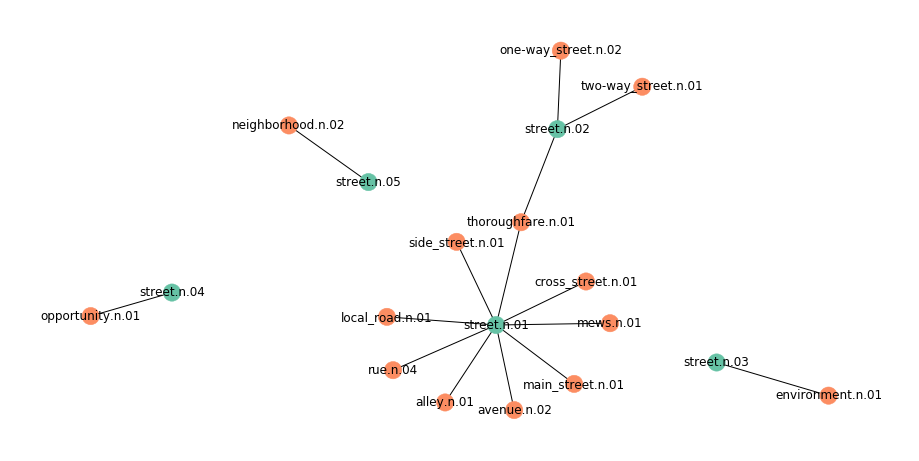

In [78]:
from collections import OrderedDict

g = nx.Graph()
g.add_edges_from(wn_is_a.as_matrix())
ss_street_roots = wn.synsets('street')
rel = lambda s: set(s.hypernyms()) | set(s.hyponyms())
ss_street_closure = [ss for root in ss_street_roots for ss in root.closure(rel, depth=1)]
cmap = sns.color_palette('Set2', n_colors=2)
node_set = OrderedDict([(f'{ss.pos()}{ss.offset():>08}', (ss.name(), cmap[0]))
                        for ss in ss_street_roots])
node_set.update([(f'{ss.pos()}{ss.offset():>08}', (ss.name(), cmap[1]))
                 for ss in ss_street_closure])

k = g.subgraph(list(node_set))
fig = plt.figure(figsize=(16, 8))
ax = fig.gca()
labels = OrderedDict([
    (n, v[0])
    for n, v in node_set.items()
])
nx.draw_networkx(k, pos=nx.spring_layout(k, iterations=21), ax=ax,
                 nodelist=[n for n in node_set if n in k.nodes],
                 labels=labels,
                 node_color=list(zip(*node_set.values()))[1])
ax.set_xticks([])
ax.set_yticks([])
sns.despine(left=True, bottom=True)